In [1]:
import xarray as xr
import numpy as np
import datetime
import pandas as pd
import gsw
from scipy import interpolate

import matplotlib as mpl
import matplotlib.pyplot as plt


import cartopy
import cartopy.feature as cfeat
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import xarray as xr
import numpy as np

from matplotlib import colors
from matplotlib import ticker
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import matplotlib.animation as animation
from IPython.display import HTML

In [2]:

reg_ext = {
    'lab': {
        'lon' : (-60, -30),
        'lat' : (50, 65),
        'name' : 'Labrador and Irminger Seas'
    },
    'gul': {
        'lon' : (-75, -45),
        'lat' : (30, 45),
        'name' : 'Gulf Stream'
    },
    'noe': {
        'lon' : (-30, -5),
        'lat' : (45, 60),
        'name' : 'North East Sea'
    }
}

In [3]:
## Function to crop the dataset
def Crops(coord, d_set):
    """
        Crops is a function that takes a data set and crops it into smaller
        region, using as parameters the values given by the dictionary 
        reg_ext.
        
        Parameters:
        ------------
            
        coord : string
            Key value that identifies the region to obtain
        
        d_set : DataArray
            Dataset to be cropped
        
        Output:
        -------
        new_ds : DataArray
            New data array corresponding to the region stated by 'coord'
    """
    
    lon1, lon2 = reg_ext[coord]['lon']
    lat1, lat2 = reg_ext[coord]['lat']
    name_fig = reg_ext[coord]['name']
    
    new_ds = d_set.sel(longitude=slice(lon1, lon2), latitude=slice(lat1, lat2))
    return(new_ds)


def Grid(data_set):
    x = data_set.longitude
    y = data_set.latitude
    
    x, y = np.meshgrid(x, y)
    return(x, y)


def No_nan(a):
    """
        No_nan is a function that helps to filter an array from nan values.
        
        Parameters:
        ------------
        a : Numpy Array
            Is the array we want to filter
        
        Output:
        -------
        a2 : Numpy Arrray
            Array with no nan values in it
    """
    nan_array = np.isnan(a)
    not_nan_array = ~ nan_array
    a2 = a[not_nan_array]
    
    return(a2)


def Map(ax, region, xtik, ytik):
    ax.set_global()
    ax.coastlines('50m')
    ax.set_xticks(xtik, crs=ccrs.PlateCarree())
    ax.set_yticks(ytik, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
    ax.set_extent(region, crs=ccrs.PlateCarree())     #lat, lon
    ax.gridlines(crs=ccrs.PlateCarree(), linewidth=1, 
                 color='gray', alpha=0.5, linestyle='-.')



def Plot_Contours(data_set, reg, minl, maxl, nlevs, nlines, tstep=None, cmap=None):
    lon1, lon2 = reg_ext[reg]['lon']
    lat1, lat2 = reg_ext[reg]['lat']
    xtik = np.linspace(lon1, lon2, num=5)
    ytik = np.linspace(lat1, lat2, num=4)

    x_n, y_n = Grid(data_set)

    projection = ccrs.PlateCarree(360)
    region = [lon1, lon2, lat1, lat2]    #Lon, Lat
    
    if not cmap:
        cmap = 'magma_r'
    
    fig, ax = plt.subplots(nrows=1, ncols=1, subplot_kw=dict(projection=projection), figsize=(10,5))    
    
    Map(ax, region, xtik, ytik)
    
    if tstep==None:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst, levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)
    else:
        contr1 = ax.contourf(x_n, y_n, data_set.mlotst[tstep], levels=np.linspace(minl, maxl, nlevs),
                                     cmap=cmap, extend='both')
        contr2 = ax.contour(x_n, y_n, data_set.zo[tstep,0], nlines, linewidths=0.5, colors='k')
        cbar = fig.colorbar(contr1, ax=ax, shrink=0.855, orientation='vertical',
                            label='MLD [m]', extend='both')  
        #cbar.set_clim(10,120)

    #fig.savefig(os.path.abspath(os.path.sep.join([".","dummy_images","Noe_%0.4d.png" % it])))
    #plt.close(fig)
    plt.show()

In [4]:
###############################################################################
###########         MAIN PROGRAM
###############################################################################

## Now working in any point in year 2005


dir_1 = '../../data_ARMOR/'
dir_2 = '../Vertical-prof/'
file1 = 'ARMOR_*.nc'
file2 = 'ARMOR_2005.nc'

just_1 = xr.open_dataset(dir_1 + file2)


In [5]:
reg = 'gul'
## File format :: t, lat, lon
gulf = Crops(reg, just_1)

In [71]:
mean_reg = gulf.mean(dim=('longitude', 'latitude'), skipna=True)
stv_reg = gulf.std(dim=('longitude', 'latitude'), skipna=True)

In [80]:
mean_reg.time.values

array(['2005-01-05T00:00:00.000000000', '2005-01-12T00:00:00.000000000',
       '2005-01-19T00:00:00.000000000', '2005-01-26T00:00:00.000000000',
       '2005-02-02T00:00:00.000000000', '2005-02-09T00:00:00.000000000',
       '2005-02-16T00:00:00.000000000', '2005-02-23T00:00:00.000000000',
       '2005-03-02T00:00:00.000000000', '2005-03-09T00:00:00.000000000',
       '2005-03-16T00:00:00.000000000', '2005-03-23T00:00:00.000000000',
       '2005-03-30T00:00:00.000000000', '2005-04-06T00:00:00.000000000',
       '2005-04-13T00:00:00.000000000', '2005-04-20T00:00:00.000000000',
       '2005-04-27T00:00:00.000000000', '2005-05-04T00:00:00.000000000',
       '2005-05-11T00:00:00.000000000', '2005-05-18T00:00:00.000000000',
       '2005-05-25T00:00:00.000000000', '2005-06-01T00:00:00.000000000',
       '2005-06-08T00:00:00.000000000', '2005-06-15T00:00:00.000000000',
       '2005-06-22T00:00:00.000000000', '2005-06-29T00:00:00.000000000',
       '2005-07-06T00:00:00.000000000', '2005-07-13

In [72]:
minimum = gulf.min(dim=('longitude', 'latitude'), skipna=True)
maximum = gulf.max(dim=('longitude', 'latitude'), skipna=True)

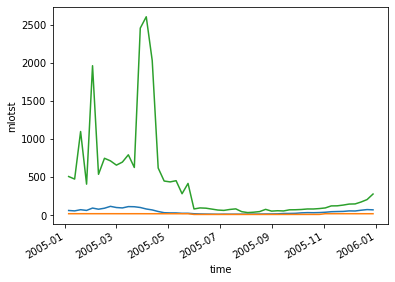

In [110]:
mean_reg.mlotst.plot()
minimum.mlotst.plot()
maximum.mlotst.plot(label='hola')
plt.show()

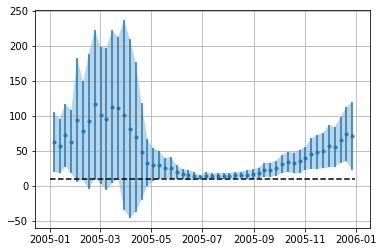

In [132]:
plt.errorbar(mean_reg.time.values, mean_reg.mlotst, 
             stv_reg.mlotst, linestyle='-')
plt.hlines(10, '2005-01', '2005-12-31', linestyles='dashed', )
plt.fill_between(mean_reg.time.values, mean_reg.mlotst-stv_reg.mlotst,
                 mean_reg.mlotst+stv_reg.mlotst, alpha=0.3)
plt.grid()
plt.show()

## Trying here zonal mean longitude distribution

In [ ]:
zonal_mean = gulf.mean(dim=('longitude'), skipna=True)
zonal_stv = gulf.std(dim=('longitude'), skipna=True)

In [144]:
zonal_mean.

<xarray.Dataset>
Dimensions:   (depth: 33, latitude: 60)
Coordinates:
  * depth     (depth) float64 0.0 10.0 20.0 30.0 ... 4e+03 4.5e+03 5e+03 5.5e+03
  * latitude  (latitude) float32 30.125 30.375 30.625 ... 44.375 44.625 44.875
Data variables:
    mlotst    (latitude) float32 44.555317 46.02187 ... 20.488436 20.015621
    so        (depth, latitude) float32 36.73847 36.72535 36.713585 ... nan nan
    to        (depth, latitude) float32 23.885399 23.751787 ... nan nan
    ugo       (depth, latitude) float32 -0.016177723 -0.03220513 ... nan nan
    vgo       (depth, latitude) float32 -0.007195512 -0.0069903852 ... nan nan
    zo        (depth, latitude) float32 0.52257174 0.52777123 ... nan nan

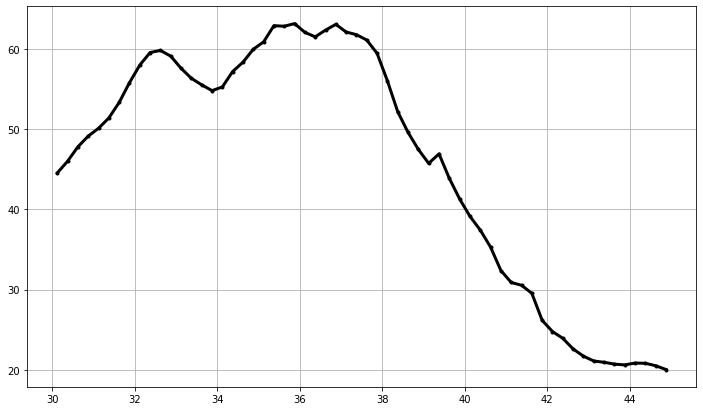

In [148]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,7))    
#for i in range(zonal_mean.latitude.size):
    #ax.errorbar(zonal_mean.time.values, zonal_mean.mlotst[:,i], 
    #             zonal_stv.mlotst[:,i])
    #plt.hlines(10, '2005-01', '2005-12-31', linestyles='dashed', )

ax.plot(mean_reg.latitude.values, mean_reg.mlotst, 
             linestyle='-', marker='.', color='k', linewidth=3.0, zorder=60)
#plt.hlines(10, '2005-01', '2005-12-31', linestyles='dashed', )
#plt.fill_between(mean_reg.time.values, mean_reg.mlotst-stv_reg.mlotst,
                 mean_reg.mlotst+stv_reg.mlotst, alpha=0.3)
ax.grid()
plt.show()